In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/barc-intern-1/OdettedataML1.csv
/kaggle/input/barc-intern-1/japan2.csv
/kaggle/input/barc-intern-1/final data.csv


In [8]:
!pip install pycaret -q

In [9]:
# Import necessary libraries
import numpy as np
import pandas as pd
from pycaret.regression import *
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
from sklearn import set_config
set_config(display='text')
import optuna
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from datetime import datetime

In [10]:
# Load the dataset
df3 = pd.read_csv("/kaggle/input/barc-intern-1/OdettedataML1.csv")

# Drop the target column to prepare for normalization
df4 = df3.drop('DeltaYS', axis=1)

In [11]:
# Normalize the features
df_norm2 = (df4 - df4.min()) / (df4.max() - df4.min())
df_norm2 = pd.concat((df_norm2, df3.DeltaYS), axis=1)

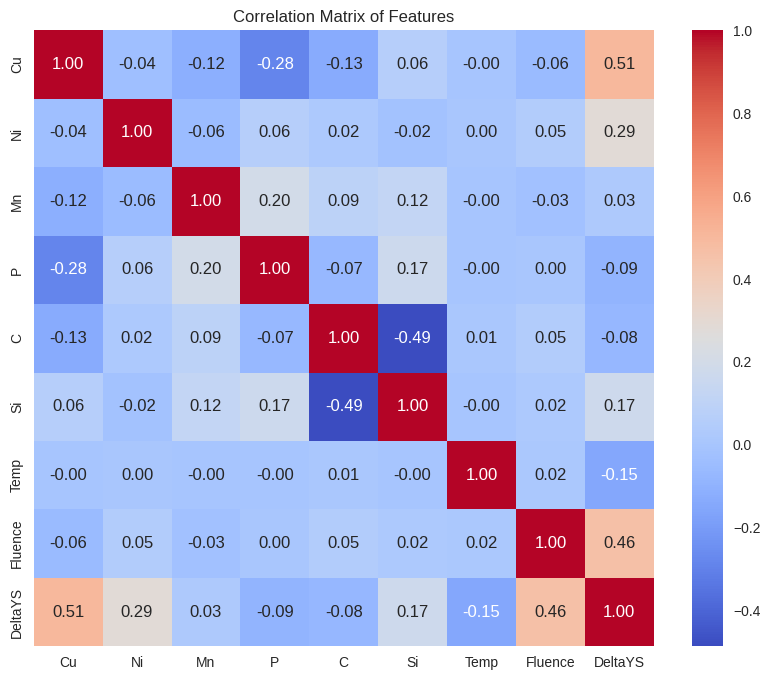

In [12]:
# Display the correlation matrix
correlation_matrix = df3.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.savefig('correlation_matrix.png')

In [13]:
# Set up PyCaret with cross-validation
# Using 5-fold cross-validation to ensure robust model evaluation
reg_setup = setup(data=df_norm2, target='DeltaYS', session_id=123, 
                 normalize=False,  # Already normalized
                 train_size=0.8,
                 fold=5,  # 5-fold cross-validation
                 verbose=False)


In [14]:
best_model = compare_models(sort='R2', n_select=1, verbose=True)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,9.7904,204.0562,14.2187,0.9637,0.3784,0.3198,0.5660
xgboost,Extreme Gradient Boosting,10.8653,271.2190,16.3627,0.9519,0.4022,0.3545,0.0600
lightgbm,Light Gradient Boosting Machine,11.0815,280.5934,16.5285,0.9507,0.3925,0.3208,18.8360
gbr,Gradient Boosting Regressor,12.6583,318.1141,17.7553,0.9435,0.4096,0.3962,0.0740
rf,Random Forest Regressor,12.6278,364.4859,19.0265,0.9349,0.4088,0.3793,0.1860
et,Extra Trees Regressor,13.4531,407.6376,20.1040,0.9275,0.4455,0.4240,0.1500
dt,Decision Tree Regressor,16.6386,627.5852,25.0177,0.8850,0.4997,0.4959,0.0140
knn,K Neighbors Regressor,20.9055,919.6240,30.2262,0.8346,0.5427,0.6318,0.0200
ada,AdaBoost Regressor,28.2018,1162.4054,34.0273,0.7915,0.8102,1.5556,0.0660
br,Bayesian Ridge,33.1378,1930.3244,43.8915,0.6514,0.7649,1.2808,0.0140


In [15]:
# Tune the best model 
tuned_model = tune_model(best_model, 
                        optimize='R2', 
                        n_iter=50,  
                        verbose=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.8518,225.8624,15.0287,0.9598,0.4347,0.3293
1,11.0720,309.2097,17.5844,0.9468,0.3815,0.3591
2,9.4745,149.0900,12.2102,0.9658,0.3787,0.3015
3,11.2888,259.5894,16.1118,0.9553,0.3964,0.3290
4,10.7824,257.7378,16.0542,0.9595,0.3761,0.3651
Mean,10.6939,240.2979,15.3979,0.9574,0.3935,0.3368
Std,0.6351,52.8250,1.7899,0.0063,0.0218,0.0231


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [16]:
final_model = finalize_model(tuned_model)

In [17]:
# Make predictions on the hold-out test set
predictions = predict_model(final_model)

# Calculate and print the R2 score on the test set
y_test = predictions['DeltaYS']
y_pred = predictions['prediction_label']
final_r2_score = r2_score(y_test, y_pred)
print(f"Final R2 Score on Test Set: {final_r2_score}")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,5.1171,45.2107,6.7239,0.9913,0.2838,0.2264


Final R2 Score on Test Set: 0.9912857101057821


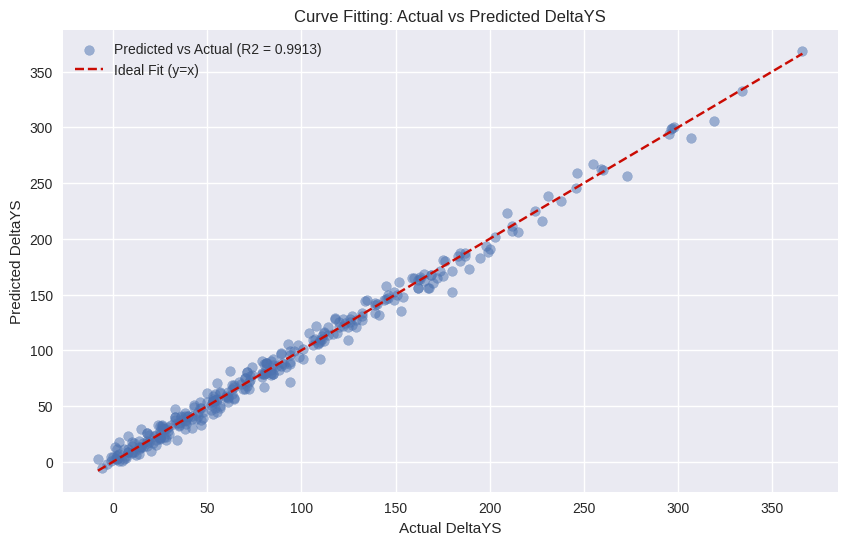

In [18]:
 #Curve Fitting (Actual vs Predicted) with R2 Score in Legend
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label=f'Predicted vs Actual (R2 = {final_r2_score:.4f})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit (y=x)')
plt.xlabel('Actual DeltaYS')
plt.ylabel('Predicted DeltaYS')
plt.title('Curve Fitting: Actual vs Predicted DeltaYS')
plt.legend()
plt.grid(True)
plt.savefig('curve_fitting.png')

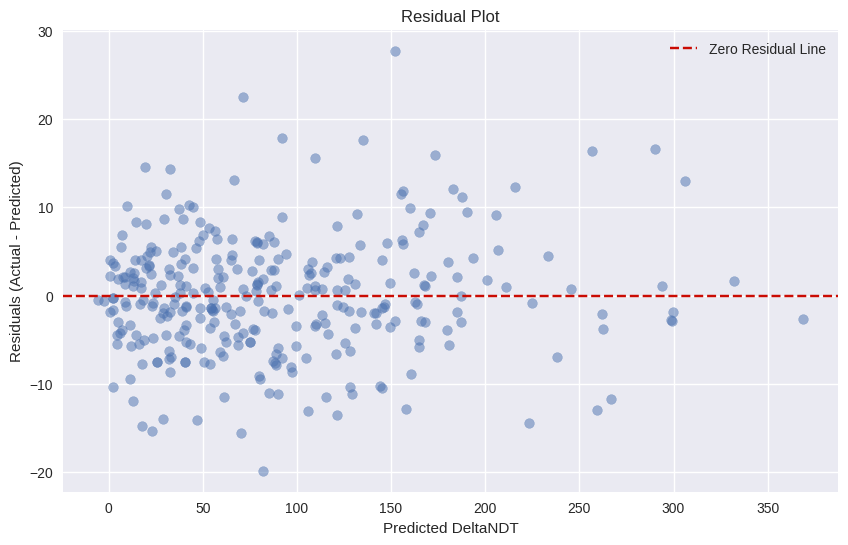

In [19]:
# Plot 2: Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.xlabel('Predicted DeltaNDT')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.savefig('residual_plot.png')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Cu', 'Ni', 'Mn', 'P', 'C', 'Si',
                                              'Temp', 'Fluence'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  <catboost.core.CatBoostRegressor object at 0x7abf3aa03b90>)]),
 'best_temperature_prediction_model.pkl')

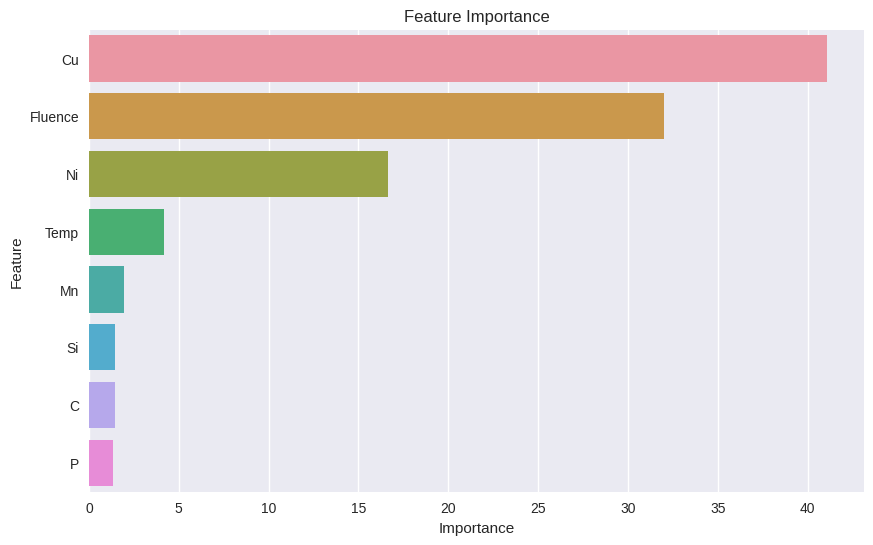

In [20]:
# Plot 3: Feature Importance

if hasattr(final_model, 'feature_importances_'):
    feature_importance = final_model.feature_importances_
    feature_names = df_norm2.drop('DeltaYS', axis=1).columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance')
    plt.savefig('feature_importance.png')
else:
    print("Feature importance not available for this model.")

# Save the model for future use
save_model(final_model, 'best_temperature_prediction_model')

In [21]:
!pip install shap -q


In [22]:
import shap
pd.set_option('display.max_columns', None)
shap.initjs()

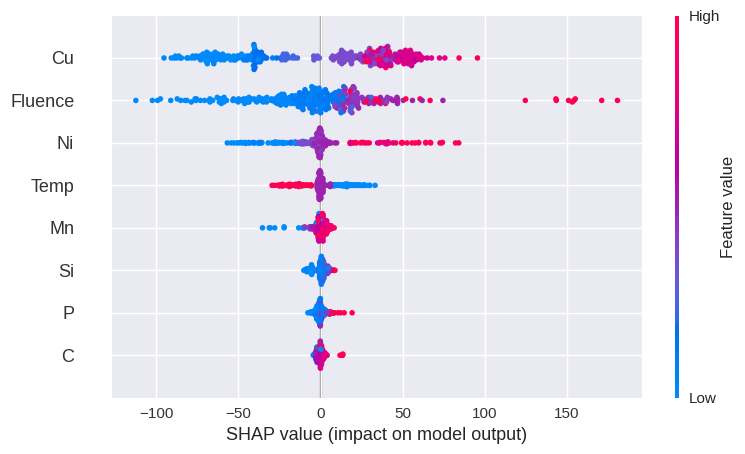

In [27]:
interpret_model(best_model)
